In [1]:
%matplotlib inline
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

## Métodos de Monte Carlo

Cuando tenemos preguntas sobre procesos, y tenemos modelos de mecanismo de un proceso, podemos usar [métodos de Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) para responderlas. Esto es extremadamente potente si ya sabes programar: hay muchas preguntas cuantitativas que son muy fáciles de formular y resolver como un experimento de Monte Carlo, pero muy difíciles de resolver de forma analítica.

### Ejemplo introductorio

Estamos jugando a cara o cruz con una moneda trucada. La moneda tiene la siguiente distribución de probabilidad:
```
cara: 0.6
cruz: 0.4
```

Si sale cruz ganas, si sale cara pierdes.

##### Pregunta 0

**¿Qué proporción de las veces ganas?**

Esta respuesta la podemos calcular trivialmente de forma analítica: `0.4`, que es simplemente la proporción de cruces esperada. Pero vamos a calcularla vía un experimento de Monte Carlo para romper mano. 

Llevamos a cabo "muchas" simulaciones de la tirada, y calculamos la proporción de cruces:

In [2]:
def estimate_win_proportion(num_trials: int) -> float:
    """
    cara: 0
    cruz: 1
    
    This simulates num_trials coin tosses and calculates num_cruces / total_tosses
    """
    trials = []
    
    for i in range(num_trials):
        if np.random.random() <= 0.4:
            trials.append(1)
        else:
            trials.append(0)
            
    return sum(trials) / len(trials)

for i in range(3):
    proportion_estimate = estimate_win_proportion(50000)
    print(proportion_estimate, "error: ", abs(0.4 - proportion_estimate))

0.39928 error:  0.0007199999999999984
0.40024 error:  0.00023999999999996247
0.40244 error:  0.0024399999999999977


Vemos que, efectivamente, la simulación de Monte Carlo nos da respuestas cercanas a la respuesta exacta, aunque en este caso sería más fácil calcular la proporción directamente.

##### Pregunta 1

Usamos la moneda en un juego con las siguientes reglas: la moneda se tira 2 veces, y dependiendo del número de cruces ganas (o pierdes) las siguientes cantidades:

| numero cruces | euros |
| ------------- | ----- |
| 0 | -2 |
| 1 | 0.5 |
| 2 | 1 |

**¿Cuál es [la media](https://en.wikipedia.org/wiki/Expected_value) de euros ganados (o perdidos) por partida si juegas a este juego con la moneda trucada?**

Esto también lo podemos calcular de forma analítica usando la [distribución binomial](https://en.wikipedia.org/wiki/Binomial_distribution), pero en este caso ya tenemos que saber más matemáticas:

$$
expected\_euros = -2 \cdot \binom{2}{0}0.6^{2} + 0.5 \cdot \binom{2}{1} 0.4 \cdot 0.6 + \binom{2}{2} 0.4 ^ 2
$$

In [3]:
exact_expected_euros = -2 * 1 * (0.6 ** 2) + 0.5 * 2 * (0.4 * 0.6) + 1 * 1 * (0.4 ** 2)
print(exact_expected_euros)

-0.31999999999999995


Si sabemos programar pero no usamos mucho las matemáticas en el día a día, igual es más fácil simularlo directamente que hacer el cálculo analítico:

In [4]:
def one_game() -> int:
    """
    This simulates a single game: a coin is tossed twice, the number of cruces is returned.
    """
    cruz_count = 0
    
    for i in range(2):
        if np.random.random() <= 0.4:
            cruz_count += 1
    return cruz_count

def average_euros(num_trials: int) -> float:
    """
    This simulates num_trials games and calculates total_euros / num_trials
    """
    
    euros = []
    for i in range(num_trials):
        cruz_count = one_game()
        if cruz_count == 0:
            euros.append(-2)
        elif cruz_count == 1:
            euros.append(0.5)
        else:
            euros.append(1)
            
    return sum(euros) / len(euros)
    
    
for i in range(3):
    estimated_expected_euros = average_euros(50000)
    print(estimated_expected_euros, "error: ", abs(estimated_expected_euros - exact_expected_euros))
    

-0.30394 error:  0.016059999999999963
-0.31898 error:  0.0010199999999999654
-0.31444 error:  0.005559999999999954


### Incertidumbre

En los ejemplos anteriores hemos hecho trampa: al haber calculado la solución analítica, podíamos calcular el error de la solución de monte carlo.

**¿Qué hacemos si no tenemos la solución analítica?**

Cuando aplicamos técnicas de monte carlo, [nuestra respuesta tiene que incluir una medida de la magnitud de su incertidumbre](https://en.wikipedia.org/wiki/Measurement_uncertainty). Esto es un tema bastante más complicado de lo que puede parecer en un principio y aplicar métodos sin pensar puede llevar a conclusiones muy erróneas.

Pero para empezar, cuando buscamos una respuesta numérica procedemos como procederíamos en un experimento normal:

1. Ejecutamos varias veces la simulación de monte carlo, sacando un conjunto de respuestas
2. Damos el resultado como la media y la [desviación típica](https://en.wikipedia.org/wiki/Standard_deviation) de este conjunto de resultados: esto nos da una caracterización de dónde esperamos que esté nuestro resultado y cuán disperso es.

Por ejemplo:



In [5]:
coin_experiment = []

for i in range(10):
    coin_experiment.append(average_euros(50000))
    
coin_experiment = np.array(coin_experiment)
coin_experiment_mean = coin_experiment.mean()
coin_experiment_std = coin_experiment.std()

print("result: {0:.4f} ± {1:.4f}".format(coin_experiment_mean, coin_experiment_std))

result: -0.3214 ± 0.0055


#### ¿Qué estamos haciendo cuando damos como resultado la media y la desviación típica?

Cuando reportamos el resultado de esta manera, nos podemos imaginar la incertidumbre de nuestro resultado como una distribución normal alrededor del valor medio con la desviación típica dada.

Si visualizamos el resultado del coin_experiment de esta manera, con los experimentos individuales como puntos rojos y la distribución en azul, queda claro: la media y la desviación típica caracterizan la distribución, que es una especie de resumen de los datos experimentales:

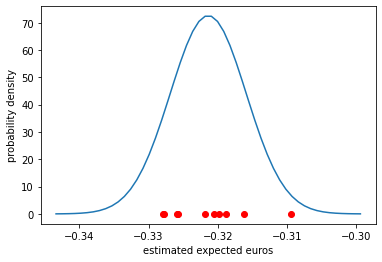

In [6]:
x = np.linspace(coin_experiment_mean - 4 * coin_experiment_std, coin_experiment_mean + 4 * coin_experiment_std)
y = scipy.stats.norm.pdf(x, loc=coin_experiment_mean, scale=coin_experiment_std)
plt.plot(x, y)
plt.plot(coin_experiment, [0 for _ in coin_experiment], 'ro')
plt.xlabel("estimated expected euros")
_ = plt.ylabel("probability density")

### Preguntas de calentamiento

Consideramos un juego con 2 dados de 6 caras: el dado `a` es justo, el dado `b` tiene un sesgo que hace que aparezca más veces el 6 que los otros números, la tabla siguiente da las probabilidades:

| dado | 1 | 2 | 3 | 4 | 5 | 6 |
| ---- | - | - | - | - | - | - |
| a | 1/6 | 1/6 | 1/6 | 1/6 | 1/6 | 1/6 |
| b | 1/12 | 1/12 | 1/12 | 1/12 | 1/12 | 7/12 |

Consideramos la suma resultante de tirar `a` y `b` y sumarlos.

#### Pregunta 1

Jugamos a un juego en el que el jugador gana si saca más de un 8 y pierde si saca menos.

**¿Qué proporción de las veces esperas ganar si juegas a este juego con los dados a y b?**

##### Respuesta 1

In [7]:
def dices_roll() -> int:
    if np.random.random() <= (7/12):
        dice2 = 6
    else:
        dice2 = np.random.randint(1, 6)
    dice1 = np.random.randint(1, 7)
            
    return dice1 + dice2


def roll(trials: int) -> int:
    eight_or_more = 0
    for i in range(trials):
        if dices_roll() > 8:
            eight_or_more += 1
    return eight_or_more / trials

for i in range(3):
    print(roll(5000))

0.48
0.4868
0.4608


#### Pregunta 2

Pintar histogramas del resultado de las sumas de estos dados cuando se ejecutan simulaciones de Monte Carlo de 10, 100, y 10000 tiradas.

Pensar en lo que quiere decir esto:
* ¿Cuanto se parecen entre sí dos histogramas de 10 tiradas distintos?
* ¿Cuanto se parecen entre sí dos histogramas de 10000 tiradas distintos?
* Hemos caracterizado los dados `a` y `b` como tablas de valores y sus probabilidades. Pinta una tabla que haga lo mismo para los valores de la suma de a y b:

| 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 |
| - | - | - | - | - | - | - | - | -- | -- | -- |
| ? | ? | ? | ? | ? | ? | ? | ? | ? | ? | ? |

In [8]:
def monte_carlo(trials:int):
    experiment = []

    for i in range(trials):
        experiment.append(roll(10))

    experiment_np = np.array(experiment)
    experiment_mean = experiment_np.mean()
    experiment_std = experiment_np.std()
    
    return experiment_mean, experiment_std, experiment_np, experiment

monte_carlo_10_mean, monte_carlo_10_std, monte_carlo_10, monte_carlo_10_clean = monte_carlo(10)

print("result: {0:.4f} ± {1:.4f}".format(monte_carlo_10_mean, monte_carlo_10_std))

result: 0.5500 ± 0.1628


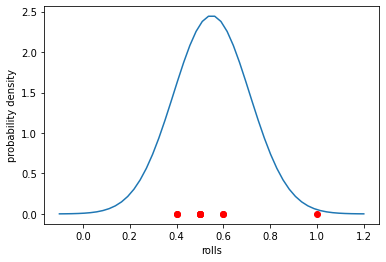

In [9]:
x = np.linspace(monte_carlo_10_mean - 4 * monte_carlo_10_std, monte_carlo_10_mean + 4 * monte_carlo_10_std)
y = scipy.stats.norm.pdf(x, loc=monte_carlo_10_mean, scale=monte_carlo_10_std)
plt.plot(x, y)
plt.plot(monte_carlo_10, [0 for _ in monte_carlo_10], 'ro')
plt.xlabel("rolls")
_ = plt.ylabel("probability density")

In [10]:
monte_carlo_100_mean, monte_carlo_100_std, monte_carlo_100, monte_carlo_100_clean = monte_carlo(100)

print("result: {0:.4f} ± {1:.4f}".format(monte_carlo_100_mean, monte_carlo_100_std))

result: 0.4490 ± 0.1425


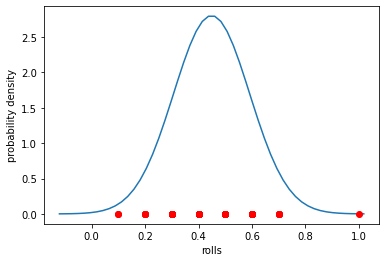

In [11]:
x = np.linspace(monte_carlo_100_mean - 4 * monte_carlo_100_std, monte_carlo_100_mean + 4 * monte_carlo_100_std)
y = scipy.stats.norm.pdf(x, loc=monte_carlo_100_mean, scale=monte_carlo_100_std)
plt.plot(x, y)
plt.plot(monte_carlo_100, [0 for _ in monte_carlo_100], 'ro')
plt.xlabel("rolls")
_ = plt.ylabel("probability density")

In [12]:
monte_carlo_1000_mean, monte_carlo_1000_std, monte_carlo_1000, monte_carlo_1000_clean = monte_carlo(1000)

print("result: {0:.4f} ± {1:.4f}".format(monte_carlo_1000_mean, monte_carlo_1000_std))

result: 0.4826 ± 0.1535


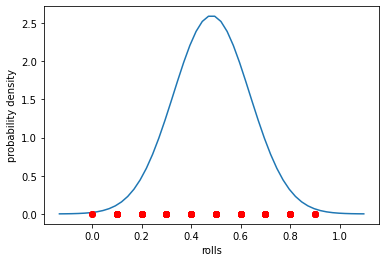

In [13]:
x = np.linspace(monte_carlo_1000_mean - 4 * monte_carlo_1000_std, monte_carlo_1000_mean + 4 * monte_carlo_1000_std)
y = scipy.stats.norm.pdf(x, loc=monte_carlo_1000_mean, scale=monte_carlo_1000_std)
plt.plot(x, y)
plt.plot(monte_carlo_1000, [0 for _ in monte_carlo_1000], 'ro')
plt.xlabel("rolls")
_ = plt.ylabel("probability density")